In [1]:
import numpy as np
import pandas as pd
import importlib
import warnings
import session_detector
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

warnings.filterwarnings("ignore")
# 自動リロード機能を有効化
%reload_ext autoreload
%autoreload 2
# 強制的にリロード
importlib.reload(session_detector)

# 日本語フォントの設定
plt.rcParams['font.family'] = 'Yu Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 再度import
from session_detector import (
    SessionParams,
    preprocess_data,
    stitch_charging_sessions,
    determine_sessions,
    check_no_movement_after_charge,
    classify_parking_duration,
    determine_session_type,
    extract_charge_to_inactive_sessions
)

In [15]:
df = pd.read_csv("./inputs/test_data.csv")
df.head()

,testcase_id,hashvin,tsu_current_time,tsu_igon_time,soc,distance_prev_m,charge_mode,Answer_session_type,tsu_rawgnss_latitude,tsu_rawgnss_longitude
0,TC001,VIN001,2024-01-15 08:30:00,2024-01-15 07:30:00,30.0,0.0,Unconfirmed,moving,NaN,NaN
1,TC001,VIN001,2024-01-15 08:35:00,2024-01-15 08:33:00,29.0,200.0,Unconfirmed,moving,NaN,NaN
2,TC001,VIN001,2024-01-15 08:40:00,2024-01-15 08:33:00,27.0,300.0,Unconfirmed,moving,NaN,NaN
3,TC001,VIN001,2024-01-15 08:45:00,2024-01-15 08:33:00,26.0,350.0,Unconfirmed,moving,NaN,NaN
4,TC001,VIN001,2024-01-15 08:50:00,2024-01-15 08:33:00,25.0,80.0,Unconfirmed,idling,NaN,NaN


In [16]:
params = SessionParams()

In [17]:
# 前処理
print("前処理中...")
preproces_df = preprocess_data(df, params)
preproces_df.to_csv("./outputs/1_preproces_df.csv", index=False)

# 充電セッション処理
print("充電セッション処理中...")
stitch_charging_sessions_df = stitch_charging_sessions(preproces_df, params)
stitch_charging_sessions_df.to_csv(
    "./outputs/2_stitch_charging_sessions_df.csv", index=False
)

# Step4-6: セッション判定
print("Step4-6: セッション判定中...")
determine_sessions_df = determine_sessions(stitch_charging_sessions_df, params)
determine_sessions_df.to_csv("./outputs/3_determine_sessions_df.csv", index=False)

# Step7: 充電後移動なし判定
print("Step7: 充電後移動なし判定中...")
check_no_movement_after_charge_df = check_no_movement_after_charge(
    determine_sessions_df, params
)
check_no_movement_after_charge_df.to_csv(
    "./outputs/4_check_no_movement_after_charge_df.csv", index=False
)

# 放置時間分類
print("放置時間分類中...")
classify_parking_duration_df = classify_parking_duration(
    check_no_movement_after_charge_df, params
)
classify_parking_duration_df.to_csv(
    "./outputs/5_classify_parking_duration_df.csv", index=False
)

# セッションタイプ統合
print("セッションタイプ統合中...")
determine_session_type_df = determine_session_type(classify_parking_duration_df)
determine_session_type_df.to_csv(
    "./outputs/6_determine_session_type_df.csv", index=False
)

# セッションタイプ統合
print("セッションタイプ統合中...")
extract_charge_to_inactive_sessions_df = extract_charge_to_inactive_sessions(
    determine_session_type_df,
    params
)
extract_charge_to_inactive_sessions_df.to_csv(
    "./outputs/7_extract_charge_to_inactive_sessions_df.csv", index=False
)


print("セッション判定完了!")


前処理中...
充電セッション処理中...
Step4-6: セッション判定中...
Step7: 充電後移動なし判定中...
放置時間分類中...
セッションタイプ統合中...
セッションタイプ統合中...
セッション判定完了!


In [20]:
def visualize_charge_to_inactive_session_single(
    determine_session_type_df, 
    extract_charge_to_inactive_sessions_df, 
    hashvin, 
    session_id, 
    params,
    start_time=None,
    end_time=None,
    buffer_hours=3,
    figsize=(16, 10)
):
    """
    指定した充電→放置セッションの統合可視化（単一グラフ）
    
    Args:
        determine_session_type_df: セッション判定済みの時系列データ
        extract_charge_to_inactive_sessions_df: 統合セッション情報
        hashvin: 対象車両ID
        session_id: 対象セッションID（charge_to_inactive_session_id）
        params: SessionParams
        start_time: 描画開始時刻（Noneの場合は自動計算）
        end_time: 描画終了時刻（Noneの場合は自動計算）
        buffer_hours: 前後の余裕時間（時間）
        figsize: 図のサイズ
    """
    
    # 対象セッション情報を取得
    target_session = extract_charge_to_inactive_sessions_df[
        (extract_charge_to_inactive_sessions_df['hashvin'] == hashvin) &
        (extract_charge_to_inactive_sessions_df['charge_to_inactive_session_id'] == session_id)
    ]
    
    if len(target_session) == 0:
        print(f"車両ID {hashvin}, セッションID {session_id} のデータが見つかりません")
        return None
    
    session_info = target_session.iloc[0]
    
    # 時刻情報の取得
    charge_start = pd.to_datetime(session_info['session_start_time'])
    charge_end = pd.to_datetime(session_info.get('charge_end_time'))
    inactive_start = pd.to_datetime(session_info.get('inactive_start_time'))
    inactive_end = pd.to_datetime(session_info.get('session_end_time'))
    
    # 描画範囲の決定
    if start_time is None:
        start_time = charge_start - timedelta(hours=buffer_hours)
    else:
        start_time = pd.to_datetime(start_time)
        
    if end_time is None:
        if pd.notna(inactive_end):
            end_time = inactive_end + timedelta(hours=buffer_hours)
        else:
            vehicle_data = determine_session_type_df[determine_session_type_df['hashvin'] == hashvin]
            end_time = pd.to_datetime(vehicle_data['tsu_current_time'].max()) + timedelta(hours=buffer_hours)
    else:
        end_time = pd.to_datetime(end_time)
    
    # 対象期間のデータを抽出
    vehicle_data = determine_session_type_df[
        (determine_session_type_df['hashvin'] == hashvin) &
        (pd.to_datetime(determine_session_type_df['tsu_current_time']) >= start_time) &
        (pd.to_datetime(determine_session_type_df['tsu_current_time']) <= end_time)
    ].copy()
    
    if len(vehicle_data) == 0:
        print(f"指定期間のデータが見つかりません")
        return None
    
    vehicle_data = vehicle_data.sort_values('tsu_current_time').reset_index(drop=True)
    
    # 時系列データの準備
    times = pd.to_datetime(vehicle_data['tsu_current_time'])
    soc = vehicle_data['soc'].fillna(method='ffill')
    distance = vehicle_data['distance_prev_m'].fillna(0)
    
    # 充電モードの数値化（階段状）
    charge_mode_map = {
        '100v charging': 1,
        '200v charging': 2, 
        'Fast charging': 3,
        'not_charging': 0
    }
    charge_mode_numeric = vehicle_data['charge_mode'].map(charge_mode_map).fillna(0)
    
    # igon_changeのタイミング
    igon_changes = vehicle_data[vehicle_data['igon_change'] == True]
    igon_change_times = pd.to_datetime(igon_changes['tsu_current_time'])
    igon_change_soc = igon_changes['soc'].fillna(method='ffill')
    
    # デザイナー視点での色選択
    colors = {
        'soc': '#1f77b4',           # 青 - SOCは電池らしい青
        'distance': '#87ceeb',       # 薄い空色 - 移動距離（統一色）
        'charge_mode': '#2ca02c',    # 緑 - 充電は自然な緑
        'charge_period': '#2ca02c',  # 充電期間も同じ緑
        'inactive_period': '#9467bd', # 紫 - 放置状態
        'igon_change': '#d62728'     # 赤 - 状態変化の警告色
    }
    
    # グラフ作成
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # 複数のY軸を作成
    ax2 = ax.twinx()  # 移動距離用
    ax3 = ax.twinx()  # 充電モード用
    
    # 3番目のY軸の位置調整
    ax3.spines['right'].set_position(('outward', 60))
    
    # 1. SOC（左軸、メイン）
    line1 = ax.plot(times, soc, color=colors['soc'], linewidth=2.5, 
                    label='SOC (%)', marker='o', markersize=3, alpha=0.9)
    ax.set_ylabel('SOC (%)', color=colors['soc'], fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelcolor=colors['soc'])
    ax.set_ylim(0, 100)  # SOCの軸を0~100で固定
    
    # igon_changeの点をプロット
    if len(igon_change_times) > 0:
        ax.scatter(igon_change_times, igon_change_soc, 
                  color=colors['igon_change'], s=120, zorder=10, 
                  label='IG状態変化', marker='X', edgecolors='white', linewidth=1)
    
    # 2. 移動距離（右軸1）- 棒グラフ
    bars = ax2.bar(times, distance, width=timedelta(minutes=4), color=colors['distance'], 
                   alpha=0.8, label='移動距離', edgecolor='white', linewidth=0.5)
    ax2.set_ylabel('移動距離 (m)', color=colors['distance'], fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=colors['distance'])
    
    # 移動判定閾値の線（移動距離と同じ色で統一感）
    ax2.axhline(y=params.DIST_TH_m, color=colors['distance'], linestyle='--', 
                alpha=0.9, linewidth=2.5, label=f'移動判定閾値 ({params.DIST_TH_m}m)')
    
    # 3. 充電モード（右軸2、直角の階段状折れ線）
    line3 = ax3.step(times, charge_mode_numeric, color=colors['charge_mode'], 
                     linewidth=3, where='post', alpha=0.9, label='充電モード')
    ax3.set_ylabel('充電モード', color=colors['charge_mode'], fontsize=12, fontweight='bold')
    ax3.tick_params(axis='y', labelcolor=colors['charge_mode'])
    ax3.set_ylim(-0.5, 3.5)
    ax3.set_yticks([0, 1, 2, 3])
    ax3.set_yticklabels(['なし', '100V', '200V', '急速'])
    
    # セッション境界の縦線（充電と放置で色分け）
    if pd.notna(charge_start):
        ax.axvline(x=charge_start, color=colors['charge_period'], linestyle=':', 
                  linewidth=4, alpha=0.8, label='充電期間')
    if pd.notna(charge_end):
        ax.axvline(x=charge_end, color=colors['charge_period'], linestyle=':', 
                  linewidth=4, alpha=0.8)
    if pd.notna(inactive_start):
        ax.axvline(x=inactive_start, color=colors['inactive_period'], linestyle=':', 
                  linewidth=4, alpha=0.8, label='放置期間')
    if pd.notna(inactive_end):
        ax.axvline(x=inactive_end, color=colors['inactive_period'], linestyle=':', 
                  linewidth=4, alpha=0.8)
    
    # タイトルとグリッド
    ax.set_title(f'充電→放置セッション統合分析\n車両ID: {hashvin}, セッションID: {session_id}', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # X軸の設定
    ax.set_xlabel('時刻', fontsize=12, fontweight='bold')
    
    # 時刻軸のフォーマット
    time_range = (end_time - start_time).total_seconds() / 3600
    if time_range <= 24:
        hours = mdates.HourLocator(interval=2)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    elif time_range <= 72:
        hours = mdates.HourLocator(interval=6)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    else:
        hours = mdates.DayLocator(interval=1)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    
    ax.xaxis.set_major_locator(hours)
    plt.xticks(rotation=45)
    
    # 凡例の統合
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    
    # セッション境界線の凡例を手動で追加
    boundary_legend = [
        plt.Line2D([0], [0], color=colors['charge_period'], linestyle=':', linewidth=4, label='充電期間'),
        plt.Line2D([0], [0], color=colors['inactive_period'], linestyle=':', linewidth=4, label='放置期間'),
    ]
    
    all_lines = lines1 + lines2 + lines3 + boundary_legend
    all_labels = labels1 + labels2 + labels3 + ['充電期間', '放置期間']
    
    # 重複ラベルを除去
    unique_legend = []
    unique_labels = []
    for line, label in zip(all_lines, all_labels):
        if label not in unique_labels:
            unique_legend.append(line)
            unique_labels.append(label)
    
    ax.legend(unique_legend, unique_labels, loc='upper left', bbox_to_anchor=(0, 1), 
              frameon=True, fancybox=True, shadow=True, fontsize=10)
    
    plt.tight_layout()    
    plt.show()


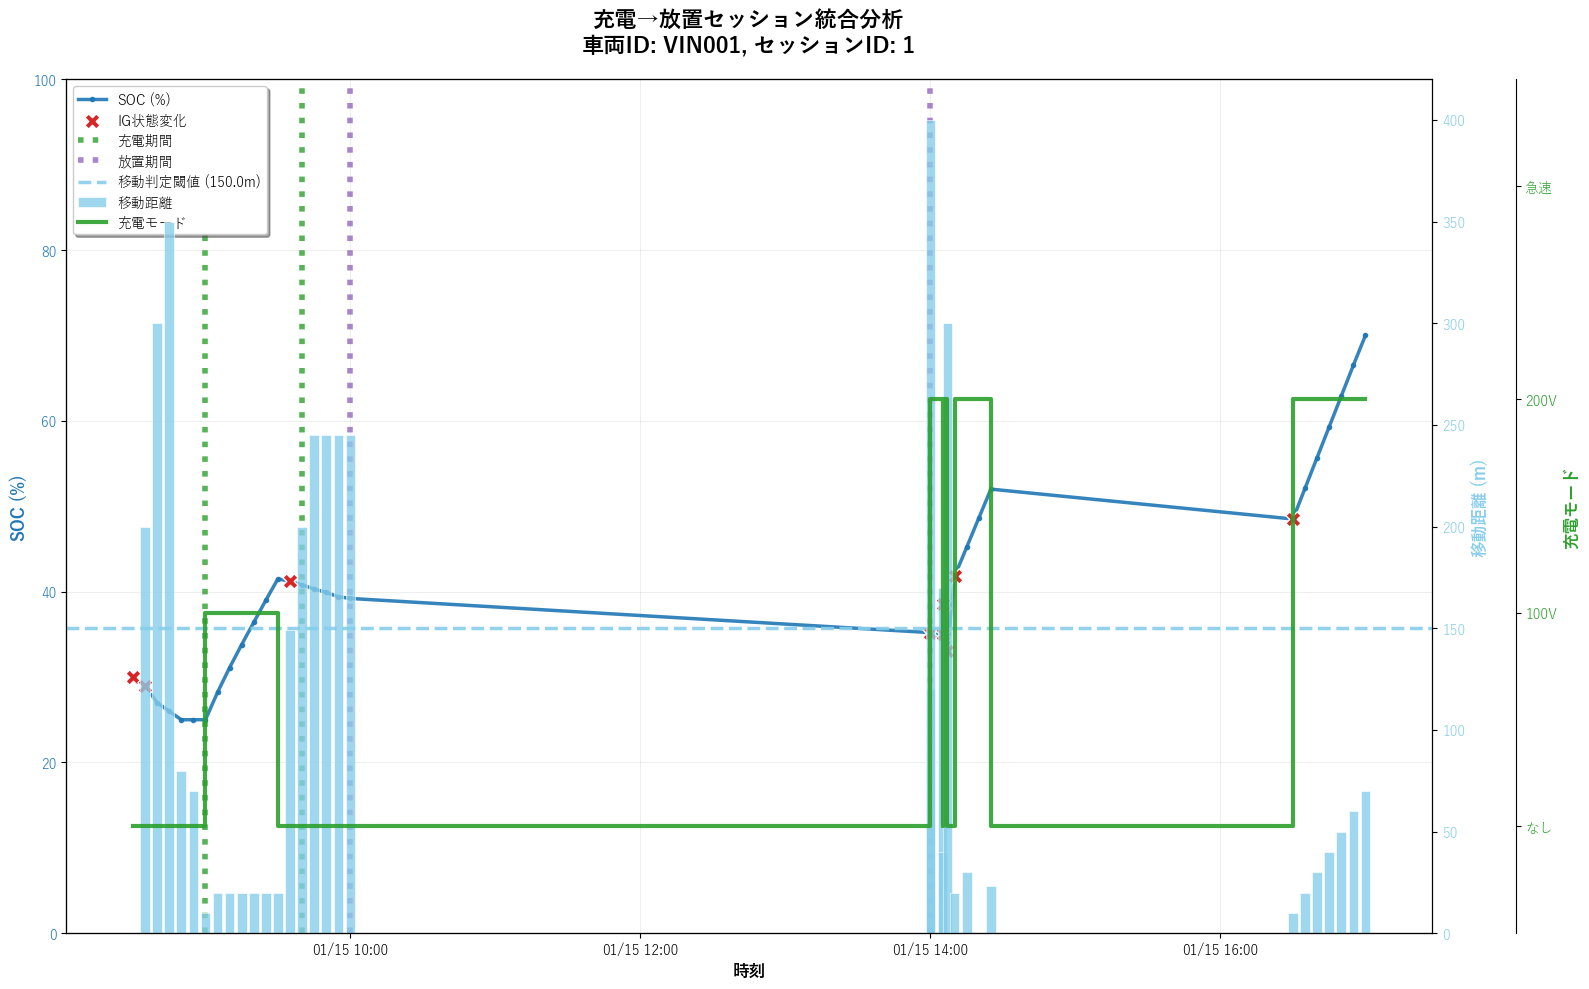

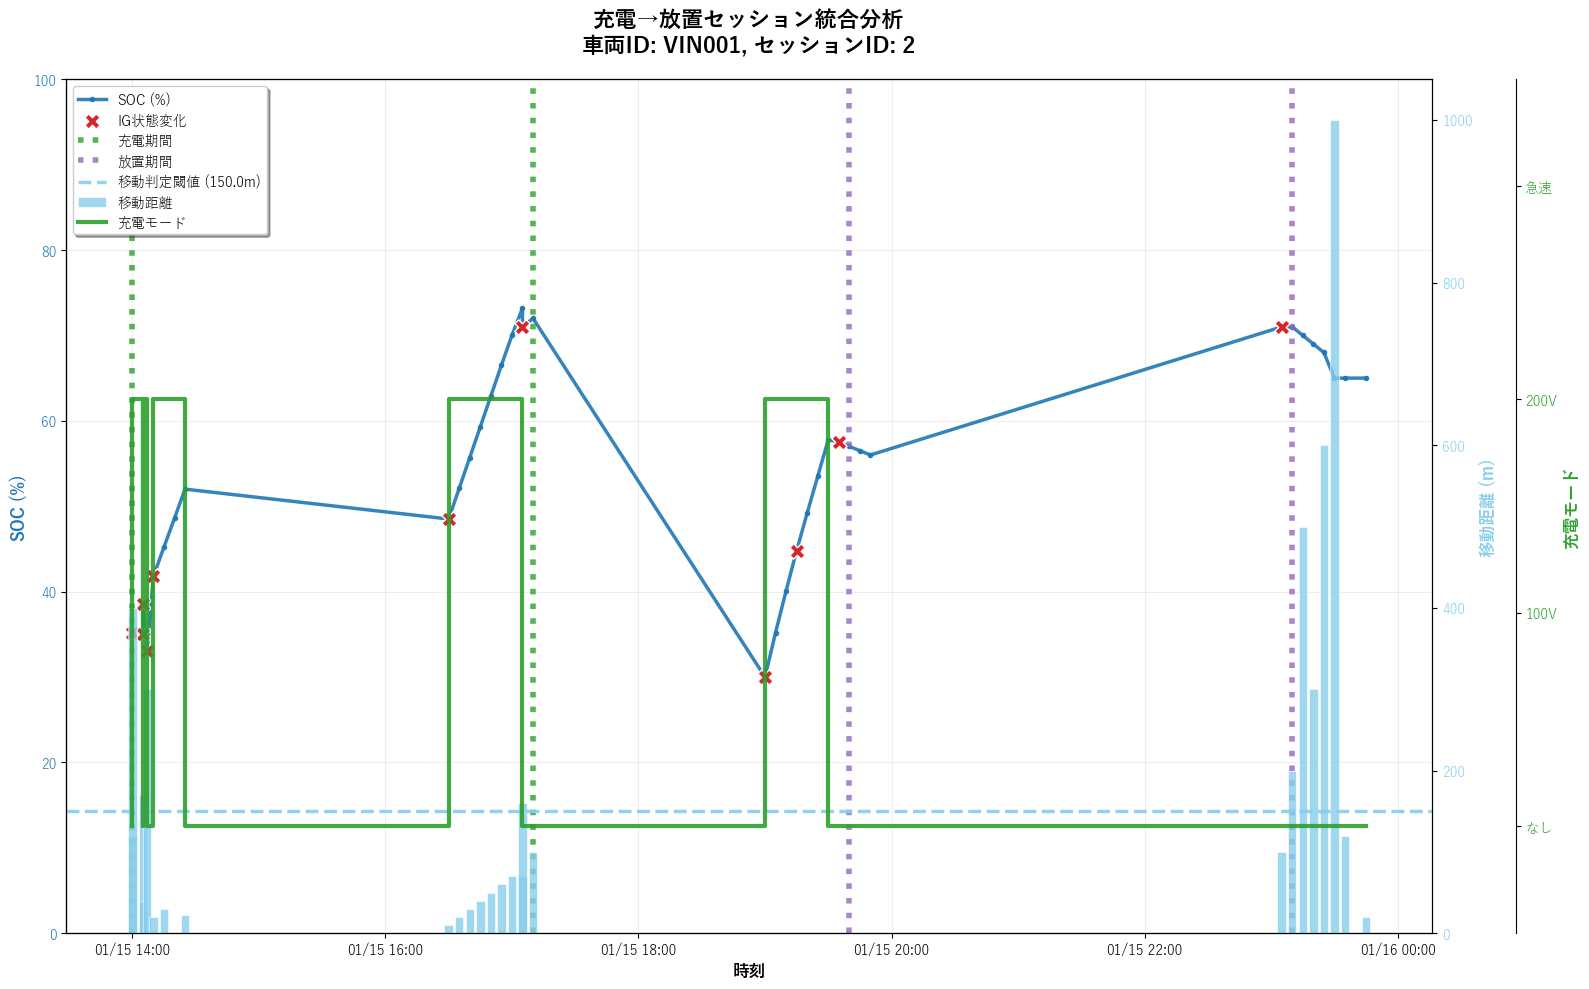

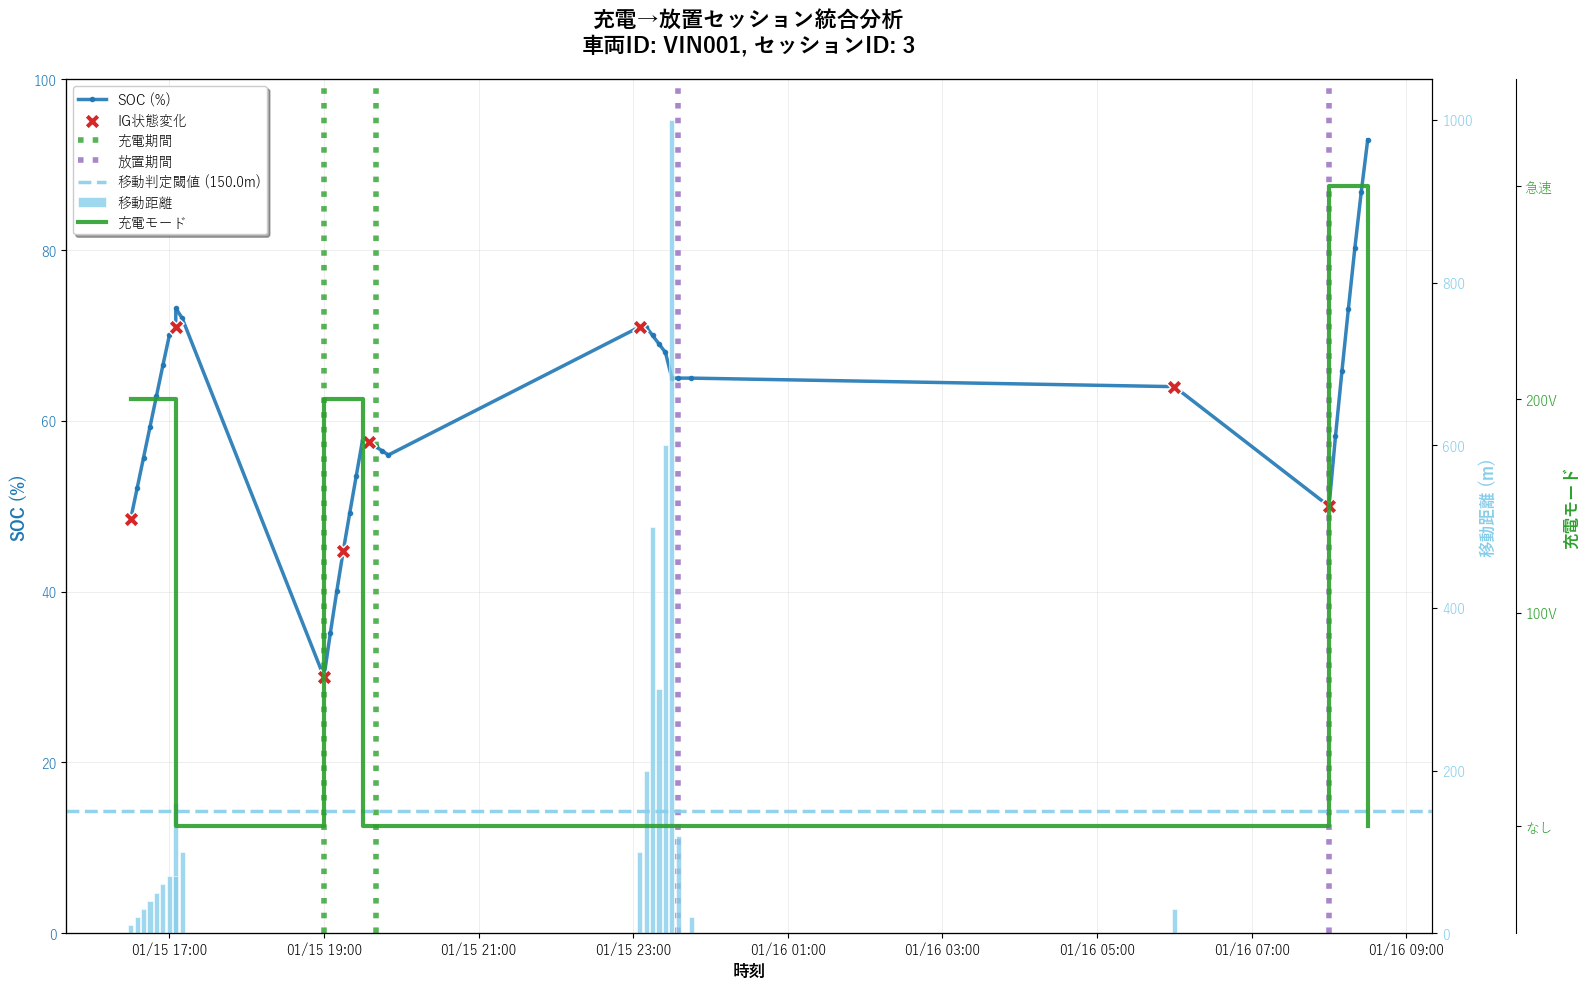

In [21]:
visualize_charge_to_inactive_session_single(
        determine_session_type_df, 
        extract_charge_to_inactive_sessions_df, 
        'VIN001', 
        1, 
        params,
        buffer_hours=3
)
visualize_charge_to_inactive_session_single(
        determine_session_type_df, 
        extract_charge_to_inactive_sessions_df, 
        'VIN001', 
        2, 
        params,
        buffer_hours=3
)
visualize_charge_to_inactive_session_single(
        determine_session_type_df, 
        extract_charge_to_inactive_sessions_df, 
        'VIN001', 
        3, 
        params,
        buffer_hours=3
)
# visualize_charge_to_inactive_session_single(
#         determine_session_type_df, 
#         extract_charge_to_inactive_sessions_df, 
#         'VIN001', 
#         4, 
#         params,
#         buffer_hours=3
# )
# visualize_charge_to_inactive_session_single(
#         determine_session_type_df, 
#         extract_charge_to_inactive_sessions_df, 
#         'VIN002', 
#         5, 
#         params,
#         buffer_hours=3
# )
# visualize_charge_to_inactive_session_single(
#         determine_session_type_df, 
#         extract_charge_to_inactive_sessions_df, 
#         'VIN003', 
#         6, 
#         params,
#         buffer_hours=3
# )